# Multi-layer Perceptron

This notebook is an example of a multi-layer perceptron with Keras (https://keras.io/)

In [1]:
# Import some needed packages
import random
random.seed(2018)
import matplotlib.pyplot as plt
%matplotlib notebook
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd

/home/petasis/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using CNTK backend


## Load data

We are going to load the tweets from SemEval 2018...

In [2]:
import pandas as pd
import glob

fpattern = '../Exercise_2-TwitterSentimentAnalysis/data/twitter-20*train-*.tsv'
filenames = [filename for filename in sorted(glob.glob(fpattern))]
print(filenames)


['../Exercise_2-TwitterSentimentAnalysis/data/twitter-2013train-A.tsv', '../Exercise_2-TwitterSentimentAnalysis/data/twitter-2015train-A.tsv', '../Exercise_2-TwitterSentimentAnalysis/data/twitter-2016train-A.tsv']


In [3]:
# Load all files into a big data frame...
column_names = ['id', 'tag', 'tweet']
df = pd.concat([pd.read_csv(f, sep="\t", quoting=3, names=column_names) for f in filenames], ignore_index=True, sort=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16173 entries, 0 to 16172
Data columns (total 3 columns):
id       16173 non-null int64
tag      16173 non-null object
tweet    16173 non-null object
dtypes: int64(1), object(2)
memory usage: 379.1+ KB


,id,tag,tweet
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,263405084770172928,negative,Not Available
2,262163168678248449,negative,Not Available
3,264249301910310912,negative,Iranian general says Israel's Iron Dome can't ...
4,262682041215234048,neutral,Not Available


In [4]:
# Drop rows having 'Not Available'...
df = df[df.tweet != 'Not Available']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12016 entries, 0 to 16172
Data columns (total 3 columns):
id       12016 non-null int64
tag      12016 non-null object
tweet    12016 non-null object
dtypes: int64(1), object(2)
memory usage: 375.5+ KB


,id,tag,tweet
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
3,264249301910310912,negative,Iranian general says Israel's Iron Dome can't ...
6,264105751826538497,positive,with J Davlar 11th. Main rivals are team Polan...
7,264094586689953794,negative,"Talking about ACT's &amp;&amp; SAT's, deciding..."
9,254941790757601280,negative,"They may have a SuperBowl in Dallas, but Dalla..."


## A function to convert a tweet into a set of words

In [5]:
import string
import re
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# turn a document into a list of clean tokens
def clean_doc(doc):
    # Remove links...
    doc = re.sub("\w+:\/\/\S+", " ", doc)
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

for tweet in df.tweet.head(10):
    print(tweet)
    print(clean_doc(tweet))

Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)
['Gas', 'house', 'hit', 'Im', 'going', 'Chapel', 'Hill', 'Sat']
Iranian general says Israel's Iron Dome can't deal with their missiles (keep talking like that and we may end up finding out)
['Iranian', 'general', 'says', 'Israels', 'Iron', 'Dome', 'cant', 'deal', 'missiles', 'keep', 'talking', 'like', 'may', 'end', 'finding']
with J Davlar 11th. Main rivals are team Poland. Hopefully we an make it a successful end to a tough week of training tomorrow.
['Davlar', 'Main', 'rivals', 'team', 'Poland', 'Hopefully', 'make', 'successful', 'end', 'tough', 'week', 'training', 'tomorrow']
Talking about ACT's &amp;&amp; SAT's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.
['Talking', 'ACTs', 'ampamp', 'SATs', 'deciding', 'want', 'go', 'college', 'applying', 'colleges', 'everything', 'college', 'stresses']
They may have a SuperBowl in Dallas, but Dallas ain't winning a Sup

## Process all tweets, and save results in the dataframe...

In [6]:
import numpy as np

df['tokens'] = np.array([ clean_doc(tweet) for tweet in df.tweet ])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12016 entries, 0 to 16172
Data columns (total 4 columns):
id        12016 non-null int64
tag       12016 non-null object
tweet     12016 non-null object
tokens    12016 non-null object
dtypes: int64(1), object(3)
memory usage: 469.4+ KB


,id,tag,tweet,tokens
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I'm going to Cha...,"[Gas, house, hit, Im, going, Chapel, Hill, Sat]"
3,264249301910310912,negative,Iranian general says Israel's Iron Dome can't ...,"[Iranian, general, says, Israels, Iron, Dome, ..."
6,264105751826538497,positive,with J Davlar 11th. Main rivals are team Polan...,"[Davlar, Main, rivals, team, Poland, Hopefully..."
7,264094586689953794,negative,"Talking about ACT's &amp;&amp; SAT's, deciding...","[Talking, ACTs, ampamp, SATs, deciding, want, ..."
9,254941790757601280,negative,"They may have a SuperBowl in Dallas, but Dalla...","[They, may, SuperBowl, Dallas, Dallas, aint, w..."


## Perform all actions also for dev/test data...

In [7]:
fpattern = '../Exercise_2-TwitterSentimentAnalysis/data/twitter-20*dev-*.tsv'
devfs    = [filename for filename in sorted(glob.glob(fpattern))]
fpattern = '../Exercise_2-TwitterSentimentAnalysis/data/twitter-20*test-*.tsv'
testfs   = [filename for filename in sorted(glob.glob(fpattern))]
df_dev   = pd.concat([pd.read_csv(f, sep="\t", quoting=3, names=column_names) for f in devfs],  ignore_index=True, sort=True)
df_test  = pd.concat([pd.read_csv(f, sep="\t", quoting=3, names=column_names) for f in testfs], ignore_index=True, sort=True)
df_dev   = df_dev[df_dev.tweet != 'Not Available']
df_test  = df_test[df_test.tweet != 'Not Available']
df_dev['tokens']  = np.array([ clean_doc(tweet) for tweet in df_dev.tweet ])
df_test['tokens'] = np.array([ clean_doc(tweet) for tweet in df_test.tweet ])

## Extract our vocabulary...

In [8]:
from collections import Counter
import itertools

vocabulary = Counter()
for tweet_tokens in itertools.chain(df.tokens, df_dev.tokens, df_test.tokens):
    vocabulary.update(tweet_tokens)

print('Total tweets: ', sum(1 for _ in itertools.chain(df.tokens, df_dev.tokens, df_test.tokens)))
vocabulary.most_common(10)

Total tweets:  30790


[('may', 4040),
 ('tomorrow', 3942),
 ('The', 1934),
 ('Im', 1754),
 ('going', 1704),
 ('amp', 1687),
 ('see', 1667),
 ('day', 1667),
 ('Friday', 1648),
 ('like', 1582)]

## Filter words using the vocabulary...

In [9]:
def token_to_vector_words(tokens, vocabulary):
    tokens = [w for w in tokens if w in vocabulary]
    return ' '.join(tokens)

print(df.tweet[0])
token_to_vector_words(df.tokens[0], vocabulary)

Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)


'Gas house hit Im going Chapel Hill Sat'

In [10]:
df['vector_tokens']      = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in df.tokens ])
df_dev['vector_tokens']  = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in df_dev.tokens ])
df_test['vector_tokens'] = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in df_test.tokens ])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12016 entries, 0 to 16172
Data columns (total 5 columns):
id               12016 non-null int64
tag              12016 non-null object
tweet            12016 non-null object
tokens           12016 non-null object
vector_tokens    12016 non-null object
dtypes: int64(1), object(4)
memory usage: 883.2+ KB


,id,tag,tweet,tokens,vector_tokens
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I'm going to Cha...,"[Gas, house, hit, Im, going, Chapel, Hill, Sat]",Gas house hit Im going Chapel Hill Sat
3,264249301910310912,negative,Iranian general says Israel's Iron Dome can't ...,"[Iranian, general, says, Israels, Iron, Dome, ...",Iranian general says Israels Iron Dome cant de...
6,264105751826538497,positive,with J Davlar 11th. Main rivals are team Polan...,"[Davlar, Main, rivals, team, Poland, Hopefully...",Davlar Main rivals team Poland Hopefully make ...
7,264094586689953794,negative,"Talking about ACT's &amp;&amp; SAT's, deciding...","[Talking, ACTs, ampamp, SATs, deciding, want, ...",Talking ACTs ampamp SATs deciding want go coll...
9,254941790757601280,negative,"They may have a SuperBowl in Dallas, but Dalla...","[They, may, SuperBowl, Dallas, Dallas, aint, w...",They may SuperBowl Dallas Dallas aint winning ...


In [11]:
# Map tag from class (positive, negative) to numbers...
df['btag']      = df.tag.astype('category').cat.codes
df_dev['btag']  = df_dev.tag.astype('category').cat.codes
df_test['btag'] = df_test.tag.astype('category').cat.codes
df_dev.head(6)

,id,tag,tweet,tokens,vector_tokens,btag
0,638060586258038784,neutral,05 Beat it - Michael Jackson - Thriller (25th ...,"[Beat, Michael, Jackson, Thriller, Anniversary...",Beat Michael Jackson Thriller Anniversary Edit...,1
1,638061181823922176,positive,Jay Z joins Instagram with nostalgic tribute t...,"[Jay, joins, Instagram, nostalgic, tribute, Mi...",Jay joins Instagram nostalgic tribute Michael ...,2
2,638083821364244480,neutral,Michael Jackson: Bad 25th Anniversary Edition ...,"[Michael, Jackson, Bad, Anniversary, Edition, ...",Michael Jackson Bad Anniversary Edition Pictur...,1
4,638125563790557184,positive,18th anniv of Princess Diana's death. I still ...,"[anniv, Princess, Dianas, death, still, want, ...",anniv Princess Dianas death still want believe...,2
5,638130776727535617,positive,@oridaganjazz The 1st time I heard Michael Jac...,"[oridaganjazz, The, time, heard, Michael, Jack...",oridaganjazz The time heard Michael Jackson si...,2
8,638162155250954241,negative,@etbowser do u enjoy his 2nd rate Michael Jack...,"[etbowser, enjoy, rate, Michael, Jackson, bit,...",etbowser enjoy rate Michael Jackson bit Honest...,0


## Lets make our vectors...

In [12]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.vector_tokens)
#print(tokenizer.word_counts)
#print(tokenizer.document_count)
#print(tokenizer.word_index)
#print(tokenizer.word_docs)
Xtrain = tokenizer.texts_to_matrix(df.vector_tokens, mode='freq')
Ytrain = df.btag
Xtest  = tokenizer.texts_to_matrix(df_test.vector_tokens, mode='freq')
Ytest  = df_test.btag
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)
#print(Ytrain[0])
#print(*Xtrain[0], sep = "\n")
from keras.utils import np_utils
Ytrain_one_hot = np_utils.to_categorical(Ytrain)
Ytest_one_hot  = np_utils.to_categorical(Ytest)
print(Ytrain_one_hot.shape)
print(Ytrain_one_hot)

(12016, 23740) (17213, 23740) (12016,) (17213,)
(12016, 3)
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


## A simple MLP model...

In [13]:
n_words = Xtest.shape[1]
print(n_words)

23740


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1519424   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 1,519,619
Trainable params: 1,519,619
Non-trainable params: 0
_________________________________________________________________


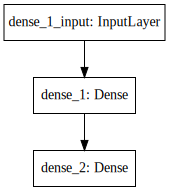

In [14]:
from keras.utils.vis_utils import plot_model

# define network
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(n_words,)))
model.add(Dense(units=3, activation='softmax'))
# compile network
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
# summarize defined model
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Fit our network...

In [15]:
# fit network
from keras import backend as K
model.fit(K.cast_to_floatx(Xtrain), K.cast_to_floatx(Ytrain_one_hot), batch_size=10, epochs=30, verbose=2)

Epoch 1/30
 - 2s - loss: 0.2097 - acc: 0.4286
Epoch 2/30
 - 2s - loss: 0.2041 - acc: 0.4288
Epoch 3/30
 - 2s - loss: 0.2035 - acc: 0.4395
Epoch 4/30
 - 2s - loss: 0.2033 - acc: 0.4412
Epoch 5/30
 - 2s - loss: 0.2033 - acc: 0.4458
Epoch 6/30
 - 2s - loss: 0.2032 - acc: 0.4516
Epoch 7/30
 - 2s - loss: 0.2032 - acc: 0.4529
Epoch 8/30
 - 2s - loss: 0.2032 - acc: 0.4511
Epoch 9/30
 - 2s - loss: 0.2031 - acc: 0.4541
Epoch 10/30
 - 2s - loss: 0.2031 - acc: 0.4600
Epoch 11/30
 - 2s - loss: 0.2030 - acc: 0.4576
Epoch 12/30
 - 2s - loss: 0.2030 - acc: 0.4751
Epoch 13/30
 - 2s - loss: 0.2030 - acc: 0.4835
Epoch 14/30
 - 2s - loss: 0.2029 - acc: 0.4881
Epoch 15/30
 - 2s - loss: 0.2029 - acc: 0.4810
Epoch 16/30
 - 2s - loss: 0.2029 - acc: 0.4866
Epoch 17/30
 - 2s - loss: 0.2028 - acc: 0.4858
Epoch 18/30
 - 2s - loss: 0.2028 - acc: 0.4778
Epoch 19/30
 - 2s - loss: 0.2027 - acc: 0.5023
Epoch 20/30
 - 2s - loss: 0.2027 - acc: 0.4895
Epoch 21/30
 - 2s - loss: 0.2026 - acc: 0.5115
Epoch 22/30
 - 2s - lo

## Evaluate our fit network...


In [16]:
# evaluate
loss, acc = model.evaluate(K.cast_to_floatx(Xtest), K.cast_to_floatx(Ytest_one_hot), verbose=2)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 54.313600


## Comparing Word Scoring Methods

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras import backend as K

def prepare_data(train_df, test_df, mode):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df.vector_tokens)
    Xtrain = tokenizer.texts_to_matrix(train_df.vector_tokens, mode=mode)
    Ytrain = np_utils.to_categorical(train_df.btag)
    Xtest  = tokenizer.texts_to_matrix(test_df.vector_tokens, mode=mode)
    Ytest  = np_utils.to_categorical(test_df.btag)
    return K.cast_to_floatx(Xtrain), K.cast_to_floatx(Ytrain), K.cast_to_floatx(Xtest), K.cast_to_floatx(Ytest)


In [18]:
# evaluate a neural network model
def evaluate_mode(Xtrain, Ytrain, Xtest, Ytest, mode):
    scores = list()
    n_repeats = 10
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        # define network
        model = Sequential()
        model.add(Dense(units=64, input_shape=(n_words,), activation='relu'))
        model.add(Dense(units=3, activation='softmax'))
        # compile network
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # fit network
        model.fit(Xtrain, Ytrain, epochs=10, verbose=2)
        # evaluate
        loss, acc = model.evaluate(Xtest, Ytest, verbose=0)
        scores.append(acc)
        print('%s %d accuracy: %s' % (mode, (i+1), acc))
    return scores

In [19]:
# run experiment
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()
for mode in modes:
    # prepare data for mode
    Xtrain, Ytrain, Xtest, Ytest = prepare_data(df, df_test, mode)
    # evaluate model on data for mode
    results[mode] = evaluate_mode(Xtrain, Ytrain, Xtest, Ytest, mode)



Epoch 1/10
 - 1s - loss: 0.5163 - acc: 0.7370
Epoch 2/10
 - 1s - loss: 0.2913 - acc: 0.8798
Epoch 3/10
 - 1s - loss: 0.1371 - acc: 0.9519
Epoch 4/10
 - 1s - loss: 0.0673 - acc: 0.9809
Epoch 5/10
 - 1s - loss: 0.0369 - acc: 0.9907
Epoch 6/10
 - 1s - loss: 0.0238 - acc: 0.9941
Epoch 7/10
 - 1s - loss: 0.0153 - acc: 0.9968
Epoch 8/10
 - 1s - loss: 0.0117 - acc: 0.9977
Epoch 9/10
 - 1s - loss: 0.0104 - acc: 0.9977
Epoch 10/10
 - 1s - loss: 0.0080 - acc: 0.9978
binary 1 accuracy: 0.6980964345996553
Epoch 1/10
 - 1s - loss: 0.5184 - acc: 0.7366
Epoch 2/10
 - 1s - loss: 0.2974 - acc: 0.8758
Epoch 3/10
 - 1s - loss: 0.1412 - acc: 0.9516
Epoch 4/10
 - 1s - loss: 0.0678 - acc: 0.9814
Epoch 5/10
 - 1s - loss: 0.0374 - acc: 0.9909
Epoch 6/10
 - 1s - loss: 0.0251 - acc: 0.9940
Epoch 7/10
 - 1s - loss: 0.0156 - acc: 0.9968
Epoch 8/10
 - 1s - loss: 0.0117 - acc: 0.9973
Epoch 9/10
 - 1s - loss: 0.0097 - acc: 0.9977
Epoch 10/10
 - 1s - loss: 0.0082 - acc: 0.9979
binary 2 accuracy: 0.694107201301206
Epo

Epoch 6/10
 - 1s - loss: 0.0231 - acc: 0.9948
Epoch 7/10
 - 1s - loss: 0.0160 - acc: 0.9965
Epoch 8/10
 - 1s - loss: 0.0126 - acc: 0.9971
Epoch 9/10
 - 1s - loss: 0.0100 - acc: 0.9975
Epoch 10/10
 - 1s - loss: 0.0087 - acc: 0.9981
count 7 accuracy: 0.6951722851894072
Epoch 1/10
 - 1s - loss: 0.5169 - acc: 0.7380
Epoch 2/10
 - 1s - loss: 0.2932 - acc: 0.8786
Epoch 3/10
 - 1s - loss: 0.1388 - acc: 0.9517
Epoch 4/10
 - 1s - loss: 0.0679 - acc: 0.9814
Epoch 5/10
 - 1s - loss: 0.0369 - acc: 0.9912
Epoch 6/10
 - 1s - loss: 0.0226 - acc: 0.9952
Epoch 7/10
 - 1s - loss: 0.0151 - acc: 0.9966
Epoch 8/10
 - 1s - loss: 0.0121 - acc: 0.9971
Epoch 9/10
 - 1s - loss: 0.0098 - acc: 0.9976
Epoch 10/10
 - 1s - loss: 0.0086 - acc: 0.9981
count 8 accuracy: 0.6957726061901652
Epoch 1/10
 - 1s - loss: 0.5166 - acc: 0.7408
Epoch 2/10
 - 1s - loss: 0.2921 - acc: 0.8786
Epoch 3/10
 - 1s - loss: 0.1376 - acc: 0.9537
Epoch 4/10
 - 1s - loss: 0.0667 - acc: 0.9804
Epoch 5/10
 - 1s - loss: 0.0365 - acc: 0.9911
Epoc

freq 3 accuracy: 0.6976316651052484
Epoch 1/10
 - 1s - loss: 0.5747 - acc: 0.6898
Epoch 2/10
 - 1s - loss: 0.4738 - acc: 0.8004
Epoch 3/10
 - 1s - loss: 0.3671 - acc: 0.8504
Epoch 4/10
 - 1s - loss: 0.2784 - acc: 0.8971
Epoch 5/10
 - 1s - loss: 0.2094 - acc: 0.9318
Epoch 6/10
 - 1s - loss: 0.1588 - acc: 0.9544
Epoch 7/10
 - 1s - loss: 0.1216 - acc: 0.9680
Epoch 8/10
 - 1s - loss: 0.0941 - acc: 0.9785
Epoch 9/10
 - 1s - loss: 0.0736 - acc: 0.9841
Epoch 10/10
 - 1s - loss: 0.0584 - acc: 0.9882
freq 4 accuracy: 0.695946891618926
Epoch 1/10
 - 1s - loss: 0.5756 - acc: 0.6864
Epoch 2/10
 - 1s - loss: 0.4762 - acc: 0.7944
Epoch 3/10
 - 1s - loss: 0.3726 - acc: 0.8475
Epoch 4/10
 - 1s - loss: 0.2839 - acc: 0.8945
Epoch 5/10
 - 1s - loss: 0.2146 - acc: 0.9296
Epoch 6/10
 - 1s - loss: 0.1626 - acc: 0.9531
Epoch 7/10
 - 1s - loss: 0.1247 - acc: 0.9668
Epoch 8/10
 - 1s - loss: 0.0966 - acc: 0.9779
Epoch 9/10
 - 1s - loss: 0.0756 - acc: 0.9842
Epoch 10/10
 - 1s - loss: 0.0596 - acc: 0.9880
freq 5 

          binary      count      tfidf       freq
count  10.000000  10.000000  10.000000  10.000000
mean    0.694642   0.694634   0.691931   0.697128
std     0.001591   0.001795   0.001573   0.001874
min     0.692403   0.692190   0.690002   0.693855
25%     0.694035   0.693226   0.691033   0.696015
50%     0.694465   0.694649   0.691890   0.697118
75%     0.695230   0.695623   0.692597   0.698271
max     0.698096   0.697361   0.695327   0.700033


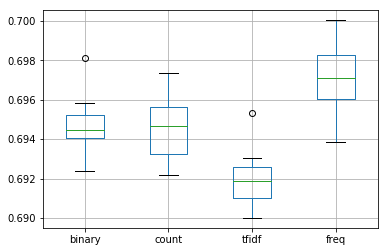

In [20]:
from matplotlib import pyplot
# summarise results
print(results.describe())
# plot results
results.boxplot()
pyplot.show()